In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [18]:
# Function to get stock data
def get_stock_data(ticker):
    df = yf.download(ticker, start="2010-01-01", end="2023-01-01")
    df = df[['Close']]  # We'll use only the 'Close' price
    return df

In [19]:
# Function to prepare the data
def prepare_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)

    X, y = [], []
    sequence_length = 60

    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i, 0])
        y.append(scaled_data[i, 0])

    X = np.array(X)
    y = np.array(y)

    # Reshape data to [samples, time steps, features] for LSTM
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

In [20]:
# Function to build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(input_shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [21]:
# Function to predict stock price
def predict_stock_price(ticker):
    df = get_stock_data(ticker)
    X, y, scaler = prepare_data(df)

    # Split into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build and train the LSTM model
    model = build_lstm_model(X_train.shape)
    model.fit(X_train, y_train, batch_size=64, epochs=5)

    # Predict on the test set
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    # Plot the results
    train = df[:train_size]
    valid = df[train_size:]
    valid = valid[:len(predictions)]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16, 8))
    plt.title(f"{ticker} Stock Price Prediction")
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
    plt.show()


Text(value='AAPL', description='Ticker:', placeholder='Enter stock ticker')

Button(description='Predict', style=ButtonStyle())

[*********************100%***********************]  1 of 1 completed

Epoch 1/5



c:\Users\anush\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0023
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.0473e-04
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 6.6744e-05
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 7.9032e-05
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 6.3692e-05
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


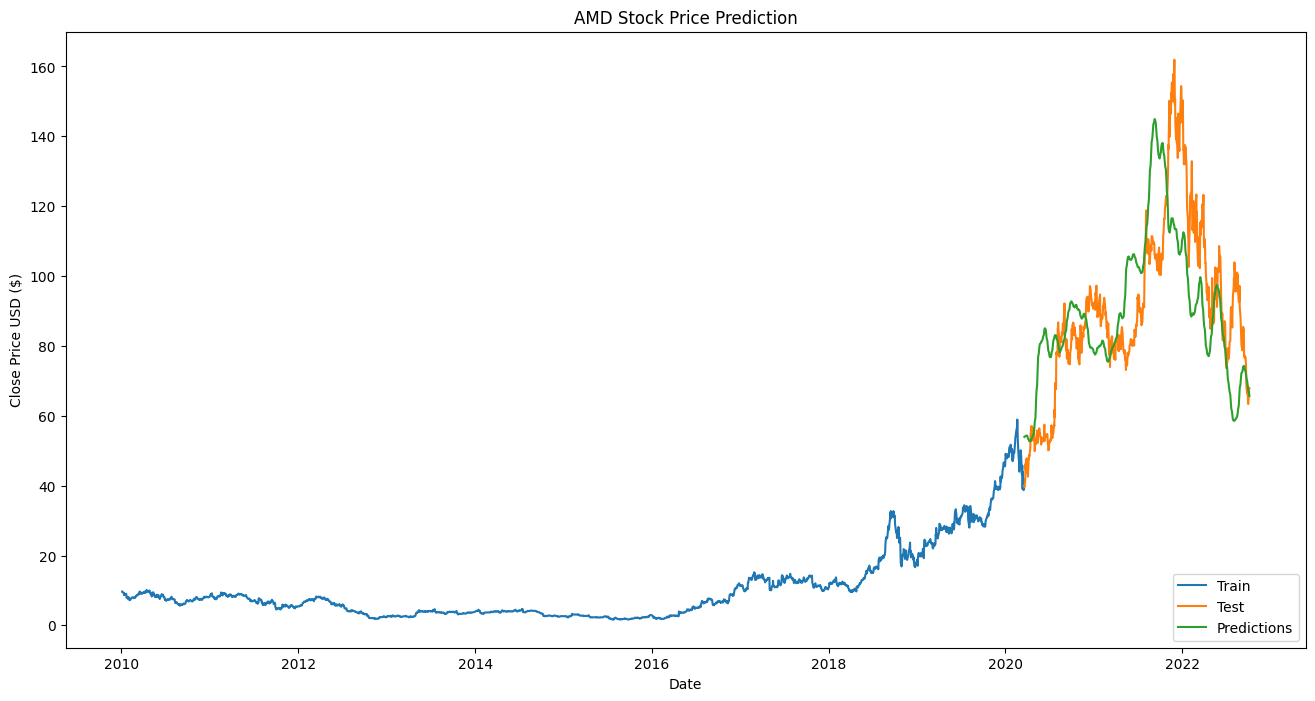

In [22]:

import ipywidgets as widgets
from IPython.display import display

# Create a widget for stock ticker input
stock_input = widgets.Text(
    value='AAPL',
    placeholder='Enter stock ticker',
    description='Ticker:',
    disabled=False
)

# Create a button to trigger prediction
button = widgets.Button(description="Predict")

# Display input widget and button
display(stock_input, button)

# Event handler for button click
def on_button_clicked(b):
    ticker = stock_input.value.upper()
    predict_stock_price(ticker)

# Bind event
button.on_click(on_button_clicked)
